In [2]:
import os
from collections import defaultdict
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM, Dense, Dropout, Input, Concatenate, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import random
import operator
from tqdm import tqdm
#from focal_loss import BinaryFocalLoss
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.models import load_model
import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.preprocessing import StandardScaler
import re
from keras import Model

In [10]:
print(os.getcwd())

/Users/phanvanhung/TagGenerator/TableData


In [11]:
!unzip ../input/code-forces.zip

unzip:  cannot find or open ../input/code-forces.zip, ../input/code-forces.zip.zip or ../input/code-forces.zip.ZIP.


In [3]:
dataset_path = '../code_forces/'

In [4]:
tags = list()
Tags_set = dict()
problems = []
with open('../_tags.txt','r') as file:
    content = file.readlines()
    for line in content:
        line = line.rstrip()
        problem = list(eval(line).items())[0][0]
        tag = list(eval(line).items())[0][1]
        problems.append(problem)
        Tags_set[problem]  = tag
        line = list(tag)
        for tag in line:
            if (tag not in tags): tags.append(tag)

In [5]:
print(tags)
print(len(tags))
print(len(content))

['constructive algorithms', 'dp', 'greedy', 'brute force', 'binary search', 'math', 'data structures', 'implementation', 'number theory', 'two pointers', 'combinatorics', 'bitmasks', 'matrices', 'meet-in-the-middle', 'graphs', 'sortings', 'trees', 'interactive', '2-sat', 'geometry', 'strings', 'dfs and similar', 'dsu', 'divide and conquer', 'shortest paths', 'games', 'hashing', 'string suffix structures', 'flows', 'expression parsing', 'chinese remainder theorem', 'probabilities', 'fft', '*special', 'graph matchings', 'ternary search', 'schedules']
37
2167


In [6]:
metrics_set = dict()
with open('../_metrics.txt','r') as file:
    content = file.readlines()
    for line in content:
        line = line.rstrip()
        info = list(eval(line).items())
        problem = info[0][1]
        code = info[1][1]
        ccn = info[2][1]
        nloc = info[3][1]
        token_count = info[4][1]
        rating = info[5][1]
        metrics_set[problem] = [int(ccn),int(nloc),int(token_count),int(rating)]
print(len(metrics_set))
# 0:ccn,1:nloc,2:token_count,3:rating

2167


In [7]:
Dataset = []
for problem in tqdm(problems):
    if (problem != '.DS_Store'):
        for text in os.listdir(dataset_path + problem + '/'):
            if (text != '.DS_Store'):
                try:
                    file = open(dataset_path + problem + '/' + text, 'r',encoding="utf8")
                except: pass
                try:
                    Dataset.append({'index': text, 
                                'problem' : problem, 
                                'Code' : file.read(), 
                                'tags': Tags_set[problem], 
                                'rating': metrics_set[problem][3],
                                'ccn': metrics_set[problem][0],
                                'token_count': metrics_set[problem][2],
                                'nloc': metrics_set[problem][1]})
                except: pass

100%|██████████| 2167/2167 [00:08<00:00, 269.58it/s]


In [8]:
## Splitting dataset depends on problem
Percent = 80
random.seed(43)
train_problems = problems
train_problems = random.sample(train_problems, int(Percent / 100 * len(train_problems)))
test_problems = [x for x in problems if x not in train_problems]
print(len(train_problems), len(test_problems))
train_set = []
for item in Dataset:
    if item['problem'] in train_problems:
        train_set.append(item)
test_set = []
for item in Dataset:
    if item['problem'] in test_problems:
        test_set.append(item)
train_set = pd.DataFrame(data = train_set)
test_set = pd.DataFrame(data = test_set)
print(train_set.shape, test_set.shape)

1733 434
(76936, 8) (19456, 8)


In [19]:
class Code_Preprocessing():
    def __init__(self,text):
        self.text = text
    def lower_text(self):
        return self.text.lower()
    def comment_remover(self):
        def replacer(match):
            s = match.group(0)
            if s.startswith('/'):
                return " " # note: a space and not an empty string
            else:
                return s
        pattern = re.compile(
            r'//.*?$|/\*.*?\*/|\'(?:\\.|[^\\\'])*\'|"(?:\\.|[^\\"])*"',
            re.DOTALL | re.MULTILINE)
        return re.sub(pattern, replacer, self.text)
    def clean_space_line(self):
        self.text = self.text.replace('\n',' ')
        self.text = ' '.join(self.text.split())
        return self.text
    def clean(self):
        self.text = self.lower_text()
        self.text = self.comment_remover()
        self.text = self.clean_space_line()
        return self.text

In [22]:
def clean_dataset(Dataset):
    Dataset = Dataset.reset_index(drop = True)
    Dataset.sort_index()
    Dataset['Code'] = Dataset['Code'].apply(lambda text: Code_Preprocessing(text).clean())
    return Dataset
train_set = clean_dataset(train_set)
test_set = clean_dataset(test_set)

,index,problem,Code,tags,rating,ccn,token_count,nloc
0,162874647.txt,1699_E,#include <cstdio> #include <cstdlib> #include ...,"[dp, greedy, math, number theory, two pointers]",2600,16,317,28
1,162885866.txt,1699_E,#include <bits/stdc++.h> using namespace std; ...,"[dp, greedy, math, number theory, two pointers]",2600,16,317,28
2,162880705.txt,1699_E,#include <bits/stdc++.h> typedef long long llt...,"[dp, greedy, math, number theory, two pointers]",2600,16,317,28
3,162854540.txt,1699_E,#include <bits/stdc++.h> using namespace std; ...,"[dp, greedy, math, number theory, two pointers]",2600,16,317,28
4,162863677.txt,1699_E,#include <bits/stdc++.h> using namespace std; ...,"[dp, greedy, math, number theory, two pointers]",2600,16,317,28
...,...,...,...,...,...,...,...,...
19657,293117.txt,3_D,#include <cstdio> #include <cstring> #include ...,[greedy],2600,8,201,26
19658,1709503.txt,3_D,#include <iostream> #include <cstdio> #include...,[greedy],2600,8,201,26
19659,16919448.txt,3_D,#include <stdio.h> #include <string.h> #includ...,[greedy],2600,8,201,26
19660,18154275.txt,3_D,#include<bits/stdc++.h> #define n 100005 using...,[greedy],2600,8,201,26


In [23]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each code.
MAX_SEQUENCE_LENGTH = 500
# Dimension of Embedding layer
EMBEDDING_DIM = 300

In [24]:
def tokenize(Dataset):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
    tokenizer.fit_on_texts(Dataset['Code'].values)
    X = tokenizer.texts_to_sequences(Dataset['Code'].values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X.shape)
    return X

In [25]:
x_train_text = tokenize(train_set)
x_test_text = tokenize(test_set)

Shape of data tensor: (78107, 500)
Shape of data tensor: (19662, 500)


In [26]:
metrics_list = ['nloc','ccn','rating','token_count']
Std = StandardScaler()
Std.fit(train_set[metrics_list])
x_train_metrics = Std.transform(train_set[metrics_list])
x_test_metrics = Std.transform(test_set[metrics_list])
print(x_train_metrics.shape, x_test_metrics.shape)

(78107, 4) (19662, 4)


In [17]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_set['tags'])
y_test = mlb.transform(test_set['tags'])
print(y_train.shape, y_test.shape)

for index in range(len(test_set)):
    if ('dp' in test_set['tags'][index]):
        print(test_set['tags'][index],index)

(76936, 37) (19456, 37)
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 0
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 1
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 2
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 3
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 4
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 5
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 6
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 7
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 8
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 9
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 10
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 11
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 12
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 13
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 14
['dp', 'greedy', 'math', 'number theory', 'two pointers'] 15
['dp', 'gr

# Predict

In [83]:
text_input = Input(shape = (500,))
metrics_input = Input(shape = (4,))

x = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x_train_text.shape[1])(text_input)
x = LSTM(100)(x)
x = Model(inputs = text_input, outputs = x)

y = Dense(32, activation = 'sigmoid')(metrics_input)
y = Model(inputs = metrics_input, outputs = y)

combined = Concatenate()([x.output,y.output])

z = Dropout(0.2)(combined)

z = Dense(37,activation = 'sigmoid')(z)

model = Model(inputs = [x.input, y.input], outputs = z)
model.compile(loss = SigmoidFocalCrossEntropy(gamma = 2), optimizer='adam')
model.summary()
epochs = 60
#batch_size = 64

history = model.fit([x_train_text,x_train_metrics], y_train, epochs=epochs, validation_split=0.1)

Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 500)]        0           []                               
                                                                                                  
 embedding_41 (Embedding)       (None, 500, 300)     15000000    ['input_70[0][0]']               
                                                                                                  
 input_71 (InputLayer)          [(None, 4)]          0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 100)          160400      ['embedding_41[0][0]']           
                                                                                           

KeyboardInterrupt: 

In [ ]:
accr = model.evaluate(x_test,y_test)
y_pred = model.predict(x_test)

In [ ]:
y_check = model.predict(x_train)
print(y_check[0],y_train[0])

In [ ]:
for index in range(len(y_check[0])):
    print(y_check[0][index], y_train[0][index])

0.049500257 0
0.0009407401 0
0.37201574 0
0.048377514 0
0.41258544 1
0.0013788342 0
0.043549895 0
0.09486961 0
0.06927055 0
0.24513781 0
0.0077203214 0
0.19545713 0
0.028743207 0
0.007840544 0
0.00051891804 0
0.0021576881 0
0.010032952 0
0.014087975 0
0.010642678 0
0.18865293 0
0.27603668 0
0.00035840273 0
0.434869 0
0.008027256 0
0.13561064 0
0.0047697127 0
0.041692317 0
0.07259092 0
0.008056164 0
0.0013177991 0
0.006245315 0
0.15730965 0
5.1713192e-05 0
0.0008200109 0
0.011280626 0
0.044044316 0
0.07355937 0


NameError: name 'history' is not defined

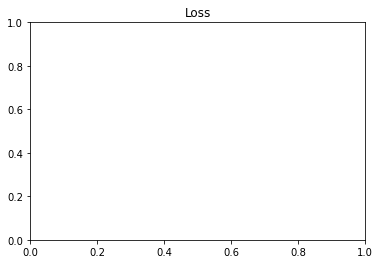

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Calculate Accuracy

In [ ]:
problem_sum = defaultdict()
problem_count = defaultdict()
problem_check = defaultdict()
for index in range(len(y_pred)):
  #y_pred[index] = np.round(y_pred[index]).astype(int)
  pos = test_set['problem'][index]
  problem_sum[pos] = np.zeros(y_pred[0].shape).astype(float)
  problem_check[pos] = np.zeros(y_test[0].shape).astype(int)
  problem_count[pos] = 0
for index in range(len(y_pred)):
  pos = test_set['problem'][index]
  problem_sum[pos] = np.sum([problem_sum[pos],y_pred[index]], axis = 0)
  problem_check[pos] = y_test[index]
  problem_count[pos] +=1
# for index in range(len(y_pred)):
# pos = test_set['problem'][index]
# problem_sum[pos] = problem_sum[pos] / problem_count[pos]
# for i in range(len(problem_sum[pos])):
# problem_sum[pos][i] = int(problem_sum[pos][i] > 0.1)

In [ ]:
def n_tag(y_pred,y_test,n,right_type_count,wrong_type_count):
  _w = 0
  _r = 0
  print(y_pred, y_test)
  indexed = list(enumerate(y_pred))
  top = sorted(indexed, key=operator.itemgetter(1))[-n:]
  index_top = list(reversed([i for i, v in top]))
  for index in index_top:
    if (y_test[index] == 1):
        _r+=1
        right_type_count[index] +=1
    else: 
        _w+=1
        wrong_type_count[index] +=1
  return _w,_r,right_type_count, wrong_type_count

In [ ]:
def visualize(type_count):
    plt.figure(figsize = (10,10))
    plt.barh(y = tags, width = type_count)
    plt.show()

1 tags and number of wrong and right prediction: 281 153
1 tags result: 35.25345622119816


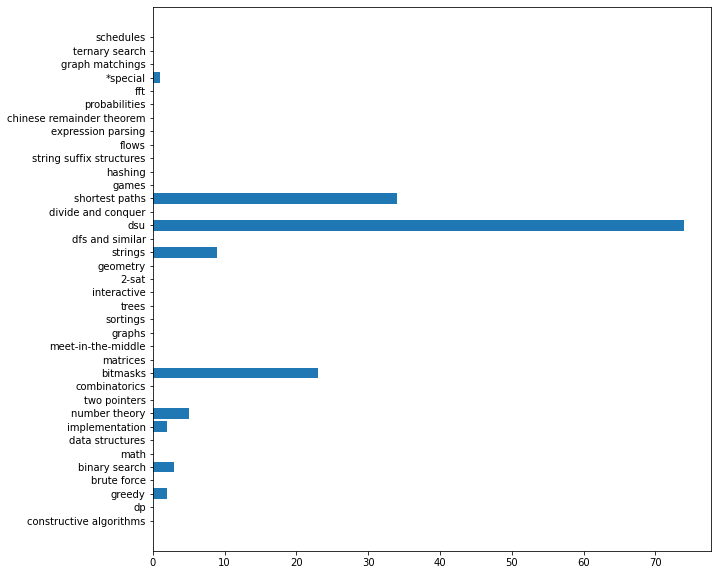

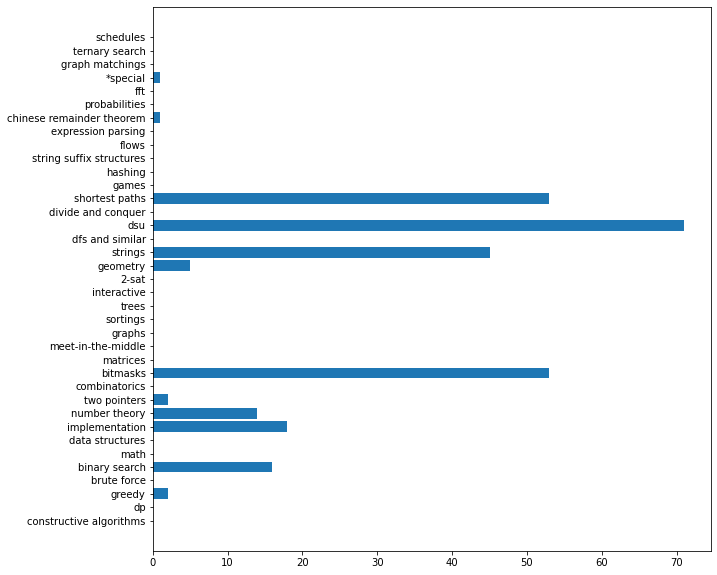

2 tags and number of wrong and right prediction: 619 249
2 tags result: 28.686635944700463


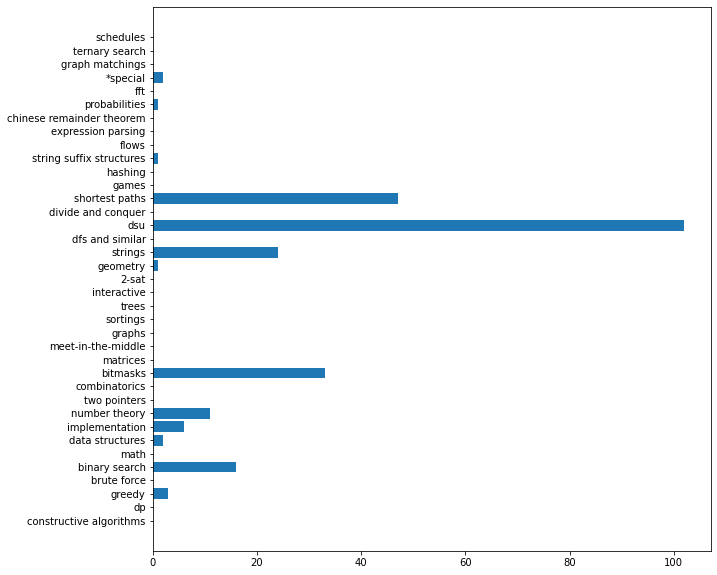

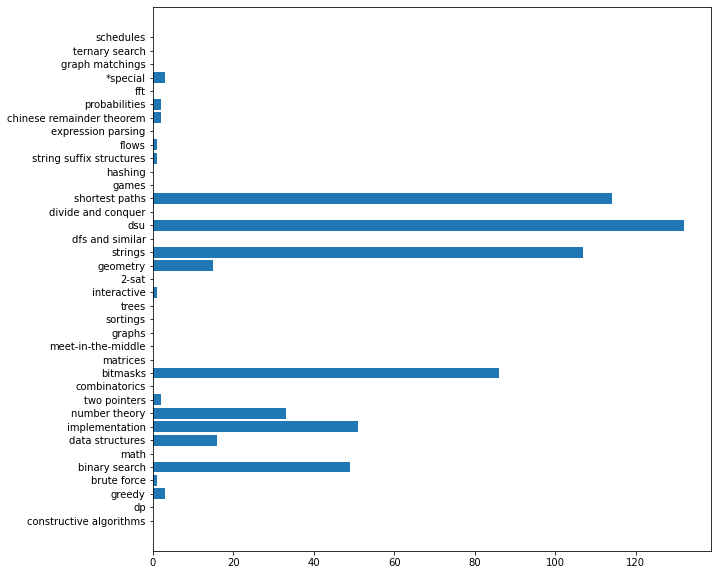

3 tags and number of wrong and right prediction: 971 331
3 tags result: 25.42242703533026


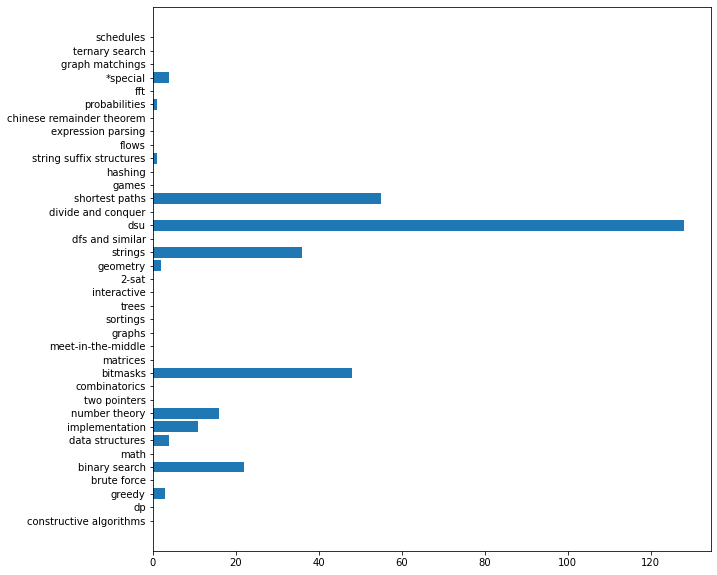

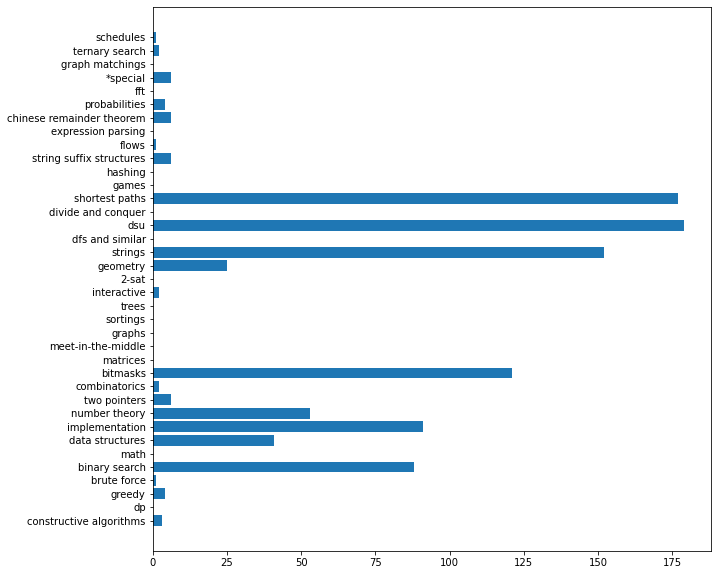

4 tags and number of wrong and right prediction: 1336 400
4 tags result: 23.04147465437788


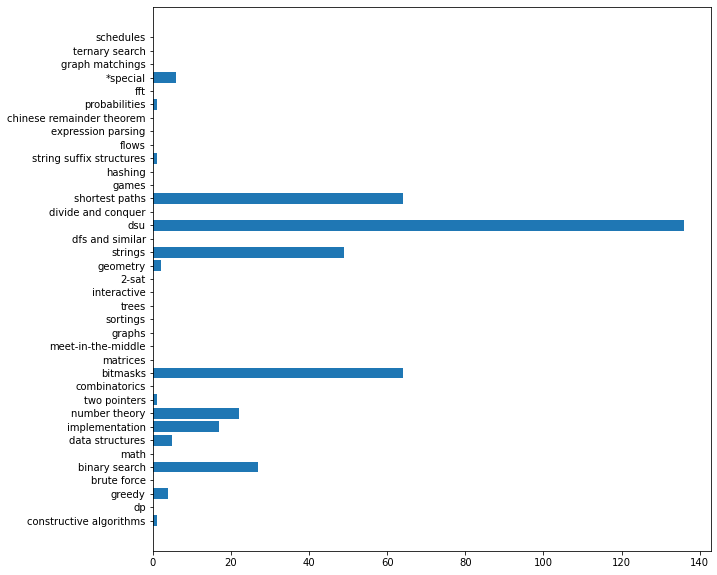

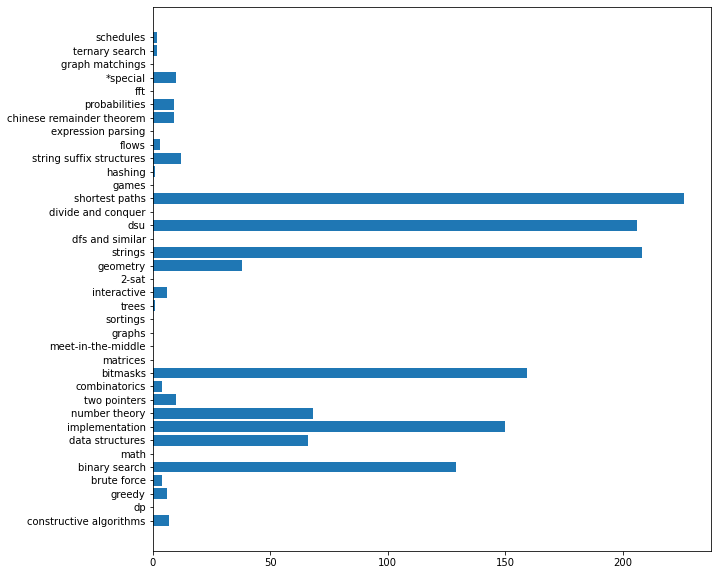

In [ ]:
N = 5
for n in range(1,N):
  wrong = 0
  right = 0
  right_type_count = [0] * 37
  wrong_type_count = [0] * 37
  for index in problem_sum.items():
    w, r, right_type_count, wrong_type_count= n_tag(problem_sum[index[0]],problem_check[index[0]],n,right_type_count,wrong_type_count)
    wrong+=w
    right+=r
  print(n,'tags and number of wrong and right prediction:',wrong,right)
  print(n,'tags result:',right/(wrong + right) * 100)
  visualize(right_type_count)
  visualize(wrong_type_count)

In [ ]:
print(len(problem_sum),len(problem_check))

In [ ]:
model = load_model('Focal_50_60')
y_check = model.predict(x_train)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
#model.save('Focal_50_60')